<a href="https://colab.research.google.com/github/alicia-tsai/privacy-open-sourced-av-data/blob/main/Waymo_Data.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Install packages

In [ ]:
# Install waymo_open_dataset package
!rm -rf waymo-od > /dev/null
!git clone https://github.com/waymo-research/waymo-open-dataset.git waymo-od
!cd waymo-od && git branch -a
!cd waymo-od && git checkout remotes/origin/master
!pip3 install --upgrade pip
!pip3 install waymo-open-dataset-tf-2-1-0==1.2.0

# Install google cloud vision package
!pip install -q google-cloud-vision

# import
import os
from os.path import isfile, join
import tensorflow.compat.v1 as tf
import math
import numpy as np
import itertools
import getpass
from tqdm import tqdm

tf.enable_eager_execution()

from waymo_open_dataset.utils import range_image_utils
from waymo_open_dataset.utils import transform_utils
from waymo_open_dataset.utils import  frame_utils
from waymo_open_dataset import dataset_pb2 as open_dataset

from google.oauth2 import service_account
from google.cloud import vision
from google.colab import drive

Cloning into 'waymo-od'...
remote: Enumerating objects: 884, done.
remote: Total 884 (delta 0), reused 0 (delta 0), pack-reused 884
Receiving objects: 100% (884/884), 14.19 MiB | 36.04 MiB/s, done.
Resolving deltas: 100% (580/580), done.
* master
  remotes/origin/HEAD -> origin/master
  remotes/origin/master
  remotes/origin/r1.0
  remotes/origin/r1.0-tf1.15
  remotes/origin/r1.0-tf2.0
  remotes/origin/r1.2
Note: checking out 'remotes/origin/master'.

You are in 'detached HEAD' state. You can look around, make experimental
changes and commit them, and you can discard any commits you make in this
state without impacting any branches by performing another checkout.

If you want to create a new branch to retain commits you create, you may
do so (now or later) by using -b with the checkout command again. Example:

  git checkout -b <new-branch-name>

HEAD is now at a476ab4 Add python 3.8 support
     |████████████████████████████████| 1.5MB 2.8MB/s 
  Found existing installation: pip 19.3.

## Authorize API and read files

In [ ]:
# modify this to suit your drive directory.
basedir = "/content/drive/My Drive/Research/MIMS"
imagedir = os.path.join(basedir, "Waymo", "0809")

def authorize_app():
    # provide API key
    print("Please provide API Key")
    APIKEY = getpass.getpass()

    # provide application credentials
    drive.mount('/content/drive')  # mount google drive
    GOOGLE_APPLICATION_CREDENTIALS = os.path.join(basedir, "GOOGLE_APPLICATION_CREDENTIALS.json")
    credentials = service_account.Credentials.from_service_account_file(GOOGLE_APPLICATION_CREDENTIALS)
    client = vision.ImageAnnotatorClient(credentials=credentials)
    
    return client


# APIKEY
client = authorize_app()
IMAGES = [f for f in os.listdir(imagedir) if isfile(join(imagedir, f))]

Please provide API Key
··········
Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/drive


## Print Images

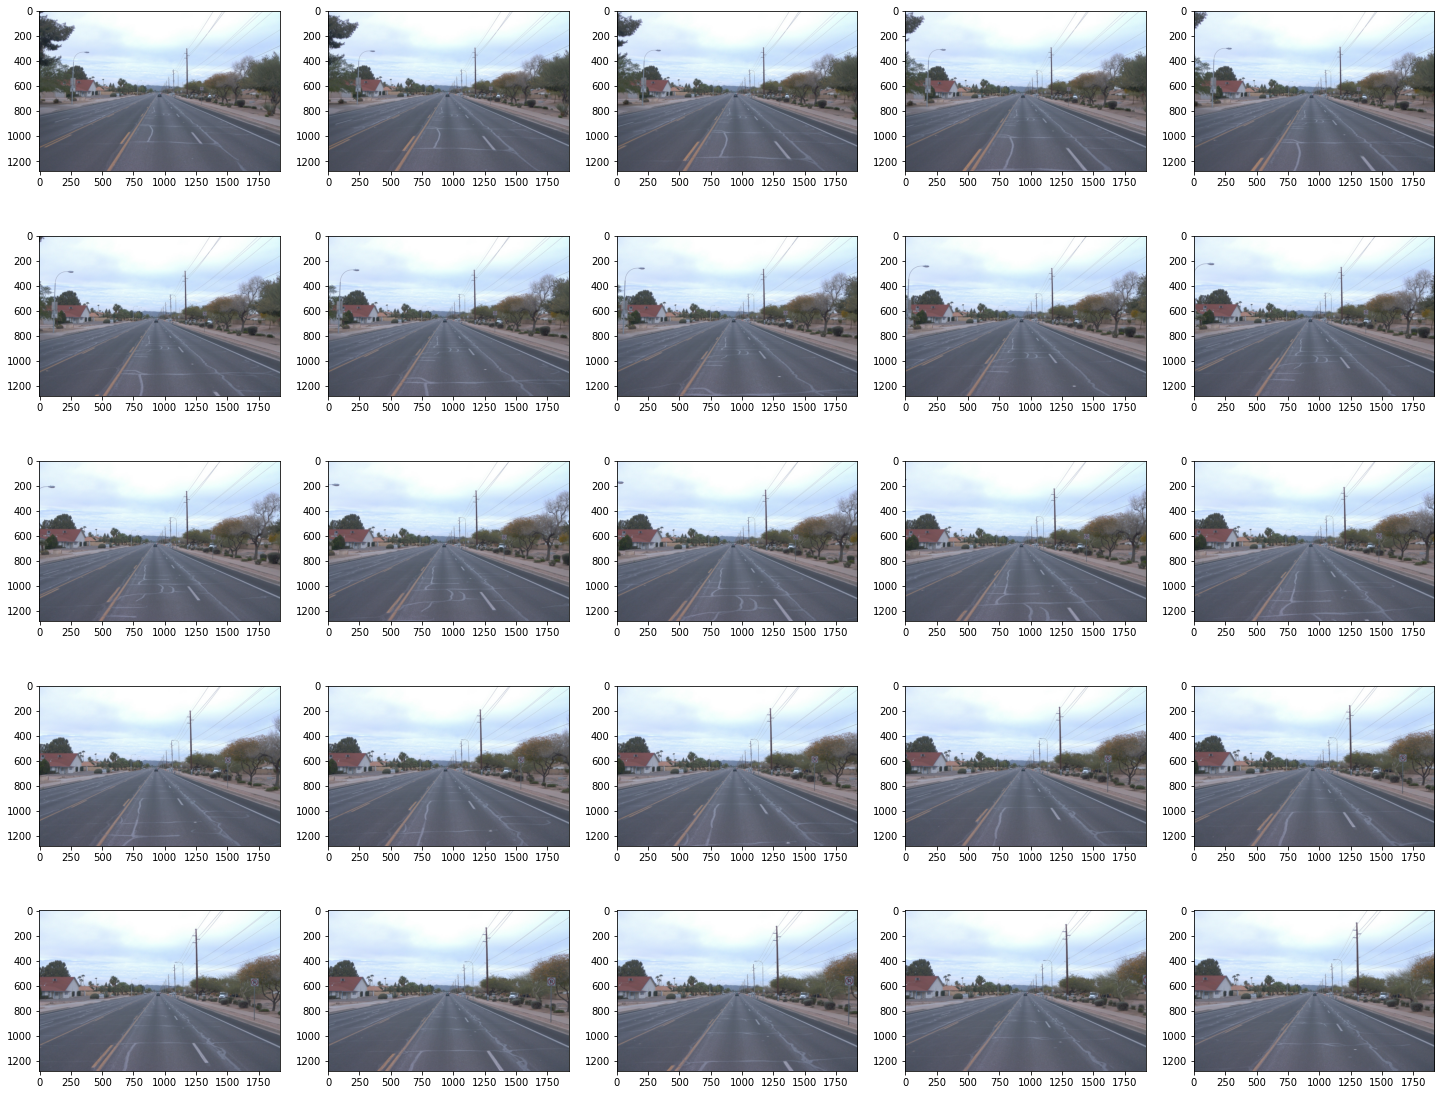

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(25, 20))

FILEPATH = join(imagedir, IMAGES[0])
dataset = tf.data.TFRecordDataset(FILEPATH, compression_type='')
i = 0
for data in dataset:
    if i >= 25:
      break
    ax = plt.subplot(5, 5, i+1)
    frame = open_dataset.Frame()
    frame.ParseFromString(bytearray(data.numpy()))
    camera_image = frame.images[0]
    plt.imshow(tf.image.decode_jpeg(camera_image.image))
    i+=1

## Run detection

In [ ]:
from tqdm import tqdm

API_results = []

for FILENAME in tqdm(IMAGES):
    FILEPATH = join(imagedir, FILENAME)
    dataset = tf.data.TFRecordDataset(FILEPATH, compression_type='')
    for data in tqdm(dataset):
        frame = open_dataset.Frame()
        frame.ParseFromString(bytearray(data.numpy()))
        
        processed = False
        for camera_image in frame.images:
            if processed:
               break
            results = {"frame_name": frame.context.name,
                       "camera_name": camera_image.name,
                       "time_of_day": frame.context.stats.time_of_day,
                       "location": frame.context.stats.location,
                       "weather": frame.context.stats.weather
            }

            content = camera_image.image
            image = vision.types.Image(content=content)

            response = client.landmark_detection(image=image)
            landmarks = response.landmark_annotations

            response = client.logo_detection(image=image)
            logos = response.logo_annotations

            response = client.text_detection(image=image)
            texts = response.text_annotations

            if not landmarks:
                results["landmarks"] = None
            else:
                results["landmarks"] = []
                for landmark in landmarks:
                    for location in landmark.locations:
                        lat_lng = location.lat_lng
                    results["landmarks"].append((landmark.description, (lat_lng.latitude, lat_lng.longitude)))
            
            if not logos:
                results["logos"] = None
            else:
                results["logos"] = []
                for logo in logos:
                    results["logos"].append(logo.description)

            if not texts:
                results["texts"] = None
            else:
                results["texts"] = []
                for text in texts:
                  vertices = [(vertex.x, vertex.y) for vertex in text.bounding_poly.vertices]
                  results["texts"].append([text.description, vertices])

            API_results.append(results)
            processed = True

  0%|          | 0/10 [00:00<?, ?it/s]
0it [00:00, ?it/s]
1it [00:01,  1.66s/it]
2it [00:02,  1.52s/it]
3it [00:05,  1.90s/it]
4it [00:07,  1.82s/it]
5it [00:09,  1.84s/it]
6it [00:10,  1.69s/it]
7it [00:11,  1.55s/it]
8it [00:13,  1.47s/it]
9it [00:14,  1.51s/it]
10it [00:15,  1.44s/it]
11it [00:18,  1.67s/it]
12it [00:19,  1.64s/it]
13it [00:20,  1.53s/it]
14it [00:22,  1.58s/it]
15it [00:24,  1.61s/it]
16it [00:25,  1.54s/it]
17it [00:27,  1.49s/it]
18it [00:28,  1.54s/it]
19it [00:30,  1.58s/it]
20it [00:32,  1.70s/it]
21it [00:34,  1.70s/it]
22it [00:35,  1.66s/it]
23it [00:37,  1.65s/it]
24it [00:39,  1.76s/it]
25it [00:41,  1.77s/it]
26it [00:43,  1.87s/it]
27it [00:45,  1.92s/it]
28it [00:47,  1.91s/it]
29it [00:48,  1.82s/it]
30it [00:50,  1.74s/it]
31it [00:52,  1.79s/it]
32it [00:54,  1.82s/it]
33it [00:55,  1.77s/it]
34it [00:57,  1.82s/it]
35it [00:59,  1.73s/it]
36it [01:00,  1.53s/it]
37it [01:01,  1.37s/it]
38it [01:03,  1.57s/it]
39it [01:04,  1.41s/it]
40it [01:06,  1

## Save Results

In [ ]:
import json
with open(join(basedir, "Waymo_API_result_0809.json"), 'w') as f:
      json.dump(API_results, f, indent=2)

In [ ]:
API_results[1]

{'camera_name': 1,
 'frame_name': '10072231702153043603_5725_000_5745_000',
 'landmarks': None,
 'location': 'location_phx',
 'logos': None,
 'texts': None,
 'time_of_day': 'Day',
 'weather': 'sunny'}

In [ ]:
len(API_results)

1982

## Miscellaneous

In [ ]:
print(frame.context.name)
print(frame.context.stats.time_of_day, frame.context.stats.location, frame.context.stats.weather)

10017090168044687777_6380_000_6400_000
Day location_sf sunny


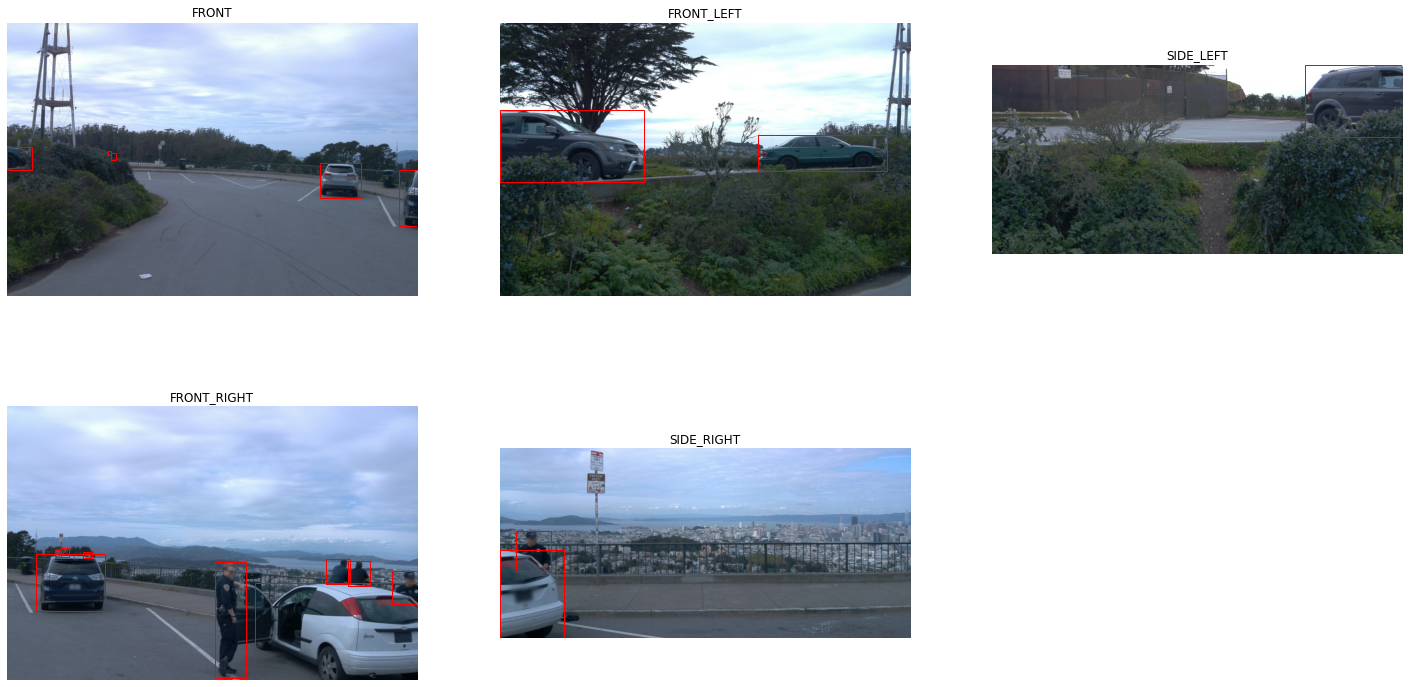

In [ ]:
import matplotlib.pyplot as plt
import matplotlib.patches as patches

def show_camera_image(camera_image, camera_labels, layout, cmap=None):
  """Show a camera image and the given camera labels."""

  ax = plt.subplot(*layout)

  # Draw the camera labels.
  for camera_labels in frame.camera_labels:
    # Ignore camera labels that do not correspond to this camera.
    if camera_labels.name != camera_image.name:
      continue

    # Iterate over the individual labels.
    for label in camera_labels.labels:
      # Draw the object bounding box.
      ax.add_patch(patches.Rectangle(
        xy=(label.box.center_x - 0.5 * label.box.length,
            label.box.center_y - 0.5 * label.box.width),
        width=label.box.length,
        height=label.box.width,
        linewidth=1,
        edgecolor='red',
        facecolor='none'))

  # Show the camera image.
  plt.imshow(tf.image.decode_jpeg(camera_image.image), cmap=cmap)
  plt.title(open_dataset.CameraName.Name.Name(camera_image.name))
  plt.grid(False)
  plt.axis('off')

plt.figure(figsize=(25, 20))

for index, image in enumerate(frame.images):
  show_camera_image(image, frame.camera_labels, [3, 3, index+1])